In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as ss
from sklearn import tree

In [2]:
#load data, in sparse format
def load_data(filename):
    f = open('dorothea/%s.data' % filename)
    I,J = [],[]
    for k in range(100000):
        line = f.readline()
        if len(line) == 0:
            print('done')
            break

        line = [int(x) for x in line.split()]
        J.extend(line)
        I.extend(k for i in range(len(line)))

    return ss.coo_matrix((np.ones(len(I)), (I,J)))


def load_labels(filename):
    f = open('dorothea/%s.labels' % filename)
    y = []
    for k in range(100000):
        line = f.readline()
        
        if len(line) == 0:
            print('done')
            break
        y.append(int(line))
    return np.array(y)


Xtrain = load_data('dorothea_train')
ytrain = load_labels('dorothea_train')

Xtest= load_data('dorothea_valid')
ytest = load_labels('dorothea_valid')

print( Xtrain.shape,  Xtest.shape, Xtrain.nnz)

done
done
done
done
(800, 100001) (350, 100001) 727760


In [3]:
def get_class_balance(y):
    counter1 = 0
    counterneg = 0
    for i in range(len(y)):
        if y[i] == 1:
            counter1+=1
        elif y[i] == -1:
            counterneg+=1
    
    return counter1/len(y) ,counterneg/len(y)

print ('class balance is currently %.2f  +1, %.2f -1' % get_class_balance(ytrain))

class balance is currently 0.10  +1, 0.90 -1


This is different from prior binary classification tasks as this one is heavily imbalanced.

In [4]:
def get_misclass(y,yhat):
    counter = 0
    counterT = 0
    i = 0
    while i < len(yhat):
        if yhat[i] == y[i]:
            counter +=1
        i+=1
        counterT +=1
    return (1 - counter/counterT)


def get_f1(y,yhat):
    detected = 0
    retrieved = 0
    relevant = 0
    i = 0
    while i < len(yhat):
        if yhat[i] == 1:
            retrieved +=1
            if y[i] == 1: 
                detected +=1
        if y[i] == 1: 
                relevant +=1        
        i+=1
    P = detected / retrieved 
    R = detected / relevant 
    x = 2 * P * R
    y = P + R
    return x / y

depth = 3
clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=depth, class_weight='balanced')
clf = clf.fit(Xtrain, ytrain)

print( get_misclass(ytrain, clf.predict(Xtrain) ), get_f1(ytrain, clf.predict(Xtrain) ))
print (get_misclass(ytest, clf.predict(Xtest) ), get_f1(ytest, clf.predict(Xtest) ))

0.04125000000000001 0.7724137931034484
0.0714285714285714 0.6031746031746031


The misclassification rate for both are less than 10 percent, thus shows that it performd a decent job. However, the F1 score does look more reasonable performance metric due to the imbalanced data set

In [5]:
f1train = []
f1test = []
depths = []
i = 2
while i < 11:
    depth = i
    clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=depth, class_weight='balanced')
    clf = clf.fit(Xtrain, ytrain)
    f1train.append(get_f1(ytrain, clf.predict(Xtrain)))
    f1test.append(get_f1(ytest, clf.predict(Xtest)))
    depths.append(i)
    i+=1

print(f1train)
    

[0.7132867132867133, 0.7724137931034484, 0.8243243243243245, 0.8783783783783784, 0.8947368421052632, 0.9342105263157894, 0.9135802469135802, 0.9743589743589743, 0.975]


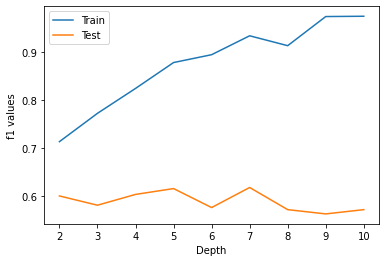

In [6]:
plt.plot(depths, f1train, label = 'Train')
plt.plot(depths, f1test, label = 'Test')
plt.xlabel('Depth')
plt.ylabel('f1 values')
plt.legend(loc='upper left')



As the depth increases the f1 vscores generally increase.

In [7]:
from sklearn.model_selection import KFold
x = Xtrain.tocsr().todense()
kf = KFold(n_splits=5)
f1trains = []
f1tests = []
depthss = []
for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = ytrain[train_index], ytrain[test_index]
    f1train = []
    f1test = []
    depths = []
    i = 2
    while i < 11:
        depth = i
        clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=depth, class_weight='balanced')
        clf = clf.fit(X_train, y_train)
        f1train.append(get_f1(y_train, clf.predict(X_train)))
        f1test.append(get_f1(y_test, clf.predict(X_test)))
        depths.append(i)
        i+=1
    f1trains.append(f1train)
    f1tests.append(f1test)
    depthss.append(depths)


Text(0, 0.5, 'f1 values')

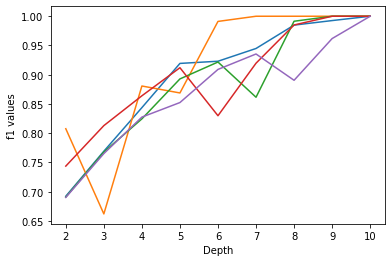

In [8]:
plt.plot(depthss[0], f1trains[0])
plt.plot(depthss[1], f1trains[1])
plt.plot(depthss[2], f1trains[2])
plt.plot(depthss[3], f1trains[3])
plt.plot(depthss[4], f1trains[4])
plt.xlabel('Depth')
plt.ylabel('f1 values')


There is a stable trend as all the f1 scores generally increase for all of the folds with depth. 

In [9]:
avg = []
i = 0
while i < 9:
    x = (f1trains[0][i] + f1trains[1][i] + f1trains[2][i] + f1trains[3][i] + f1trains[4][i])/5
    avg.append(x)
    i+=1

Text(0, 0.5, 'f1 values')

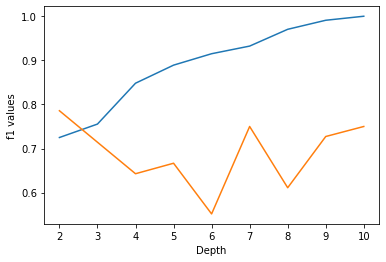

In [10]:
plt.plot(depths, avg)
plt.plot(depths, f1test)


plt.xlabel('Depth')
plt.ylabel('f1 values')


It does not correspond too well to the test set F score, thus this venture was not 100% successful. 